### Ćwiczenie zaliczeniowe

Celem ćwiczenia jest:

- przećwiczenie wiedzy o klasyfikatorach


Zadanie:

Część 1:

- Pobierz bazę danych covertype (https://archive.ics.uci.edu/ml/datasets/Covertype)
należy wykorzystać funkcję: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html
- zwizualizuj dane przy użyciu TSNE
- napisz własna implementację klasyfikatora kNN
- naucz klasyfikator kNN
- naucz KNeighborsClassifier ze scikit-learn
- przeanalizuj i porównaj wyniki klasyfikatorów (confusion matrix, wykres k vs accuracy)
- napisz własną implementację klasyfikatora NM
- naucz klasyfikator NM
- porównaj accuracy własnego NM z obiema wersjami kNN
- porównaj zużycie pamięci obu typów klasyfikacji


Część 2:

- wykorzystując bazę danych GTSRB zbuduj własną reprezentację danych o znakach (własny wektor cech, minimum 5 cech)
- zwizualizuj dane przy użyciu TSNE
- w oparciu o stworzony zestaw cech porównaj klasyfikatory z części 1

Pobieranie bazy danych covtype oraz importowanie niezbędnych bibliotek

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_covtype
import csv
import random
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

covtype = fetch_covtype(data_home=None, download_if_missing=True, random_state=None, shuffle=False, return_X_y=False)

Ignorowanie kolumn kategorycznych, tak aby operowac na 10 atrybutach numerycznych

In [2]:
data = covtype.data[:,:10]
target = covtype.target

In [3]:
random_indices = np.array(random.sample(range(len(data)), 2000))

Normalizacja danych, aby umożliwić poprawną wizualizację danych przy użyciu TSNE

In [4]:
data_normalized = (data - np.tile(np.min(data, axis=0), (581012,1))) / (np.tile(np.max(data, axis=0) - np.min(data, axis=0), (581012, 1)))

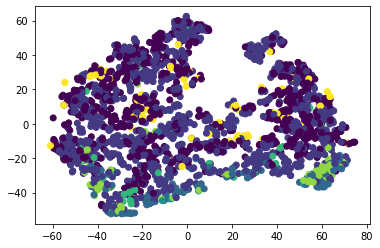

In [5]:
model = TSNE(learning_rate=500, perplexity=30, n_iter=2000, init='pca')

transformed = model.fit_transform(data_normalized[random_indices])
transformed_target = target[random_indices]

xs=transformed[:,0]
ys=transformed[:,1]

plt.figure()
plt.scatter(xs,ys,c=transformed_target)
plt.show()

Wizualizacja całego zbioru danych (581012 x 10).

Wygenerowanie tego wykresu zajęło 8h dlatego nie uruchamiałem już ponownie tej komórki (wykres ten wysyłałem przez MS Teams oraz mam zapisane jego zdjęcie w razie potrzeby)

In [ ]:
model = TSNE(learning_rate=500, perplexity=30, n_iter=2000, init='pca')

transformed = model.fit_transform(data)

xs=transformed[:,0]
ys=transformed[:,1]

plt.figure()
plt.scatter(xs,ys,c=target)
plt.show()

Wyizolowanie 10 pierwszych cech (cechy numeryczne)

In [6]:
features = covtype.data[:,:10]
labels = covtype.target

In [7]:
class KNearestNeighboursClassifier:
    def __init__(self, k):
        self.k = k
        self.training_features = 0
        self.training_labels = 0
        self.predicted_labels = np.array([])

    def load_training_data(self, training_set, training_labels):  # Training on the training set
        self.training_features = self.normalize(training_set)
        self.training_labels = training_labels

    def predict(self, test_set):  # Predicting the labels of a test set
        test_features = self.normalize(test_set)
        predicted_labels = list()
        
        for index, value in enumerate(test_features):
            nearest_neighbours_labels = np.array(self.training_labels)[np.argsort(np.sum(np.sqrt((np.tile(test_features[index], (np.shape(self.training_features)[0], 1)) - self.training_features) ** 2), axis=1))[:self.k].astype(int)]
            predicted_labels.append(max(set(nearest_neighbours_labels), key=list(nearest_neighbours_labels).count))

        return predicted_labels

    @staticmethod
    def normalize(dataset):
        return (dataset - np.tile(np.min(dataset, axis=0), (dataset.shape[0], 1))) / (np.tile(np.max(dataset, axis=0) - np.min(dataset, axis=0), (dataset.shape[0], 1)))

Z powodów optymalizacyjnych, zmniejszyłem zbiór danych czterokrotnie i dokonałem podziału na zbiór treningowy oraz testowy

In [8]:
# reshape_multiplier = 4
# samples = features.shape[0] / reshape_multiplier
samples = 50000

features_small = resample(features, n_samples=samples, replace=False, stratify=features, random_state=2)
labels_small = resample(labels, n_samples=samples, replace=False, stratify=labels, random_state=2)

training_set_small, test_set_small, training_labels_small, test_labels_small = train_test_split(features_small, labels_small, test_size=0.33, random_state=3)

Klasyfikacja covtypes przy użyciu mojego klasyfikatora kNN dla k = <1,3>

In [9]:
covtype_k_for_knn = [1,2,3] # Wartosci k dla których przeprowadzona będzie klasyfikacja
covtype_knn_acc_scr = list() # Lista accuracy_score dla wszystkich wartości hiperparametru k


for ki in covtype_k_for_knn:
    classifier = KNearestNeighboursClassifier(k=ki)
    classifier.load_training_data(training_set_small, training_labels_small)
    predicted_groups = classifier.predict(test_set_small)
    covtype_knn_acc_scr.append(accuracy_score(test_labels_small, predicted_groups, normalize=True))
    
    if ki==3: # Tworzenie confusion_matrix dla k=3
        actual_series = pd.Series(test_labels_small, name='Actual')
        predicted_series = pd.Series(predicted_groups, name='Predicted')
        df_confusion = pd.crosstab(actual_series, predicted_series)
    
df_confusion # Wyświetlanie confusion_matrix

Predicted,1,2,3,4,5,6,7
Actual,,,,,,,
1,2818,3003,70,0,7,15,25
2,3763,4090,111,1,9,22,40
3,495,527,9,0,0,0,2
4,55,28,1,0,0,0,0
5,136,140,0,0,0,0,1
6,247,275,6,0,0,2,0
7,281,307,4,1,0,6,3


Klasyfikacja znaków przy użyciu klasyfikatora kNN z biblioteki scikit dla k = <1,7>

In [10]:
scikit_k_for_knn = [1,2,3,4,5,6,7] # Ponieważ implementacja z biblioteki scikit jest wydajniejsza, mogę pozwolić sobie na wiekszy zakres hiperparametru k
scikit_knn_acc_scr = list()

for ki in scikit_k_for_knn:
    classifier = KNeighborsClassifier(n_neighbors=ki)
    classifier.fit(training_set_small, training_labels_small) 
    predicted_groups = classifier.predict(test_set_small)
    scikit_knn_acc_scr.append(accuracy_score(test_labels_small, predicted_groups, normalize=True))
    
    if ki==3:
        actual_series_scikit = pd.Series(test_labels_small, name='Actual')
        predicted_series_scikit = pd.Series(predicted_groups, name='Predicted')
        df_confusion_scikit = pd.crosstab(actual_series_scikit, predicted_series_scikit)
        
df_confusion_scikit # Wyświetlanie confusion_matrix

Predicted,1,2,3,4,5,6,7
Actual,,,,,,,
1,2834,3014,54,1,4,16,15
2,3844,4038,88,1,6,28,31
3,514,506,9,0,0,1,3
4,47,36,0,0,1,0,0
5,135,140,2,0,0,0,0
6,230,292,5,0,1,2,0
7,280,314,6,0,0,0,2


Rysowanie wykresu k vs accuracy dla obu implementacji kNN

kNN accuracy_scores [0.37606060606060604, 0.4027272727272727, 0.4195151515151515]
kNN-scikit accuracy_scores [0.374, 0.40424242424242424, 0.4172727272727273]


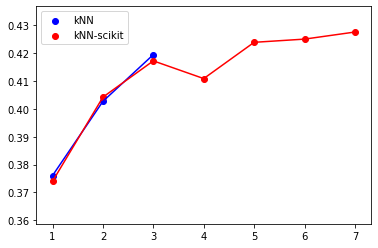

In [11]:
print("kNN accuracy_scores", covtype_knn_acc_scr)
print("kNN-scikit accuracy_scores", scikit_knn_acc_scr[:3])

plt.scatter(covtype_k_for_knn, covtype_knn_acc_scr, c='b', label='kNN')
plt.plot(covtype_k_for_knn, covtype_knn_acc_scr, c='b') # Dodawanie linii miedzy punktami

plt.scatter(scikit_k_for_knn, scikit_knn_acc_scr, c='r', label='kNN-scikit')
plt.plot(scikit_k_for_knn, scikit_knn_acc_scr, c='r')

plt.legend(loc='upper left')
plt.show()

### Porównanie wyników klasyfikatorów

#### Confusion matrices and accuracy scores:

Z confusion matrix dla k=3 dla mojej implementacji oraz implementacji z biblioteki widać, że jest podobna dokladność wyników

#### Execution times:

Z powodów optymalizayjnych, wykonałem uczenie klasyfikatora kNN w mojej implementacji tylko dla k=<1,3>, gdyż nawet dla czterokrotnie mniejszego zbioru danych oraz braniu pod uwagę tylko cech numerycznych (145253 x 10) czas wykonania klasyfikacji był ~30 min. 

Zmieniłem również zbiór danych do 50000 próbek i czas wykonywania klasyfikacji dla k = <1,3> był ~7 min

Dla porównania klasyfikacja przy użyciu kNN z scikit dla k=<1,7> wykonała się w ~1 min

#### Wykres k vs accuracy

Z wyresu powyżej widać, że accuracy_score obu implementacji dla k=<1,3> jest podobny (różnica miedzy implementacjami to około 0.2%).

Implementacja klasyfikatora NearestMean (NM)

In [12]:
class NearestMeanClassifier():
    def __init__(self):
        self.training_labels = 0
        self.centroids = list()
        
    def load_training_data(self, training_set, training_labels):
        self.calculate_centroids(self.normalize(training_set), training_labels)
        self.training_labels = np.unique(training_labels)

    def predict(self, test_set):
        test_features = self.normalize(test_set)
        predicted_labels = list()
        distances = list()
        
        for index, value in enumerate(test_features):
            predicted_labels.append(self.training_labels[np.argsort(np.sum(np.sqrt((np.tile(test_features[index], (np.shape(self.centroids)[0], 1)) - self.centroids) ** 2), axis=1))[:1][0]]) 
        return predicted_labels
    
    def calculate_centroids(self, training_set, training_labels):
        unique, counts = np.unique(training_labels, return_counts=True)
        
        for label in np.unique(training_labels):
            self.centroids.append(np.sum(training_set[:][training_labels==label], axis=0) / counts[label-1]) # Calculating Mi for the current class Ci
    
    @staticmethod
    def normalize(dataset):
        return (dataset - np.tile(np.min(dataset, axis=0), (dataset.shape[0], 1))) / (np.tile(np.max(dataset, axis=0) - np.min(dataset, axis=0), (dataset.shape[0], 1)))

Klasyfikacja covtypes przy użyciu mojego klasyfikatora NM bez hiperparametru (równoważne z k = 1)

In [13]:
training_set, test_set, training_labels, test_labels = train_test_split(features, labels, test_size=0.33, random_state=3)

nm_classifier = NearestMeanClassifier()
nm_classifier.load_training_data(training_set, training_labels)
predicted_groups = nm_classifier.predict(test_set)

actual_series = pd.Series(test_labels, name='Actual')
predicted_series = pd.Series(predicted_groups, name='Predicted')
df_confusion = pd.crosstab(actual_series, predicted_series)

nm_accuracy_score = accuracy_score(test_labels, predicted_groups, normalize=True)
print(nm_accuracy_score)
df_confusion

0.38748996004881764


Predicted,1,2,3,4,5,6,7
Actual,,,,,,,
1,31692,8692,384,334,11166,2865,14440
2,18808,30912,1364,1938,27133,8323,5482
3,0,486,2207,3694,1629,3657,0
4,0,0,55,706,6,136,0
5,4,687,57,151,1853,345,0
6,0,326,750,1568,617,2544,0
7,1657,20,2,6,630,27,4381


NM (or NearestCentroid) example from scikit library to compare the result of my classifier

In [14]:
clf = NearestCentroid()
clf.fit(training_set, training_labels)
pred = clf.predict(test_set)

scikit_nm_accuracy_score = accuracy_score(test_labels, pred, normalize=True)
print(scikit_nm_accuracy_score)

0.19163528638634775


### Porównanie NM z kNN

#### Accuracy score i czas wykonania

Accuracy score dla NM wyniósł ~38.7%, czyli nieco gorzej niż metoda kNN. Stało się tak dlatego, gdyż metoda NM jest podatna na niepoprawne próbki które mają wpływ na położenie centroidu. 

Czas wykonania NM wyniósł ok. 10 s, więc NM było szybsze od kNN - scikit (ok. 4 min) oraz znacznie szybsze od mojej implementacji kNN (ok. 20 min)

#### Zużycie pamięci i złożoność obliczeniowa kNN oraz NM

Klasyfikator kNN ma wieksze zużycie pamięci, ponieważ musi pamiętać wszystkie próbki. Ponadto złożoność obliczeniowa jest znaczna, gdyż musimy liczyć odległośc każdej próbki z setu testowego od każdej probki z setu treningowego.

W przypadku klasyfikatora NM, zużycie pamięci oraz złożoność obliczeniowa jest znacznie zredukowana, ponieważ klasyfikator musi tylko pamiętać centroidy dla każdej z klas oraz obliczenia centroidów są wykonywane jednorazowo, a później liczona odległość jest zwykłą odległością między dwoma punktami

# Część 2

Moja implementacja funkcji 'readTrafficSigns'. Do Pana implementacji zczytywania znaków dodałem castowanie tablicy na typ int, ponieważ w innym przypadku, podczas dodawania wyświetlany był niepoprawny wynik gdyż wartość komórki nie mogła być wieksza od 255 (np 255 + 197 = 196). 

Dodatkowo dodałem część kodu, która przycina każdy z obrazów do 14x14 px (7 px od srodka w każdą stronę). Dzięki temu, będę w stanie stworzyć vektor cech, który będzie mieć taki sam rozmiar dla każdej próbki

In [15]:
def my_read_traffic_signs(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '\\' + format(c, '05d') + '\\' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header !!!!!!!!!!!!!!!!!!TUTAJ NALEŻY KONIECZKIE ZMIENIĆ ORYGINAŁ
        # loop over all images in current annotations file
        count = 0
        for row in gtReader:
            x1,y1,x2,y2 = map(int,row[3:7])
            
            # Wyliczanie środków zdjęcia (środek jest wylicany na podstawie środka w płaszczyźnie X)
            mean_x = np.floor((x2 - x1) / 2)
            mean_y = mean_x
            img_size = 7 # Polowa rozmiaru zdjęcia liczona od srodka
            
            # Nowe wartosci x1,x2,y1,y2
            x1 = int(mean_x - img_size)
            x2 = int(mean_x + img_size)
            y1 = int(mean_y - img_size)
            y2 = int(mean_y + img_size)
            
            # Zczytywanie obrazów oraz castowanie tablicy do int, aby móc poprawnie wykonywać obliczenia, potrzebne do wyznaczenie cech
            images.append(np.array(plt.imread(prefix + row[0]).astype(int))[x1:y2,x1:x2]) # the 1th column is the filename
            labels.append(int(row[7])) # the 8th column is the label
        gtFile.close()
    return np.array(images), np.array(labels)

Funkcja licząca średnią wartość pixeli dla wszsytkich kanałow (Mean Pixel Value of Channel)

Funkcja 'convert_to_mean_of_channels' sumuje odpowiadające sobie pixele w macierzy R, G oraz B, a następnie wylicza ich średnia. Dzięki temu możemy wykorzystać wartości pixeli dla wszystkich kanałow, bez potrzeby przechowywania trzech kanałow osobno

Wcześniej rozważałem stworzenie cech na podstawie grayscale zdjęć, jednakże aktualne podejście pozwoli wykorzystać wszystkie składowe korosytyczne, a więc pełną informację jaką mamy o zdjęciach

In [16]:
def convert_to_mean_of_channels(arr):
    result = [np.add(np.add(img[:,:,0], img[:,:,1]), img[:,:,2])/3 for img in arr]
    return result

Wczytywanie zdjęć oraz odpowiadających im etykiet

In [17]:
path = r".\GTSRB\Training" # Ścieżka do głownego folderu ze zdjęciami
images, labels = my_read_traffic_signs(path)

Utworzenie wektora etykiet zawierającego podział na grupy znaków, zamiast podziału na podtypy.

In [18]:
class_names=["zakazu", "ostrzegawcze", "informacyjne", "nakazu"]
sign_groups = [0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,3,3,3,3,3,3,3,3,0,0]
labels_groups = np.array([sign_groups[cls] for cls in labels])

Generowanie listy (1,26640,14,14) 2D ndarray'ów (14,14) cech, wykorzystując funkcję 'convert_to_mean_of_channels' oraz pozbycie się jednego zbędnego wymiaru i zamienienie na ndarray o wymiarach (26640,14,14)

In [19]:
features_matrix = convert_to_mean_of_channels(images)
features_matrix = np.asarray([features_matrix][0])

Stworzenie pustego wektora cech o rozmiarze (26640,196) oraz zmienienie kształtu z 2D ndarray cech (14,14) do poprawnego 1D ndarray cech (196,)

In [20]:
features = np.zeros((len(features_matrix), (features_matrix[0].shape[0] * features_matrix[0].shape[1]))) # 26640 x 196 (14*14)

for i in range(0, features_matrix.shape[0]):
    features[i] = np.reshape(features_matrix[i], (features_matrix[i].shape[0]*features_matrix[i].shape[1]))

Wizualizacja, przy użyciu TSNE, mojej reprezentacji danych o znakach z bazy danych GTSRB

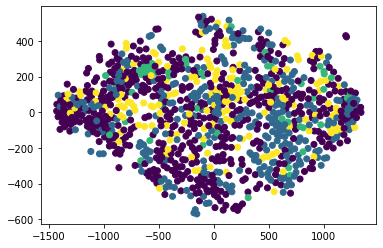

In [21]:
random_indices = np.array(random.sample(range(features.shape[0]), 1000))

model = TSNE(learning_rate=800, perplexity=50, n_iter=2500, init='pca')

transformed = model.fit_transform(features[random_indices])
transformed_labels = labels_groups[random_indices]

xs=transformed[:,0]
ys=transformed[:,1]

plt.figure()
plt.scatter(xs,ys,c=transformed_labels)
plt.show()

Utworzenie setu treningowego (67%) oraz testowego (33%), które zostaną wykorzystane do klasyfikacji kNN, kNN-scikit oraz NM w celu porównania efektywności tych metod w klasyfikacji znaków

In [22]:
signs_training_set, signs_test_set, signs_training_labels, signs_test_labels = train_test_split(features, labels_groups, test_size=0.33, random_state=3)

Klasyfikacja znaków przy użyciu mojego klasyfikatora kNN dla k = <1,3>

In [23]:
signs_k_for_knn = [1,2,3] # Wartosci k dla których przeprowadzona będzie klasyfikacja
signs_knn_acc_scr = list() # Lista accuracy_score dla wszystkich wartości hiperparametru k


for ki in signs_k_for_knn:
    classifier = KNearestNeighboursClassifier(k=ki)
    classifier.load_training_data(signs_training_set, signs_training_labels)
    predicted_groups = classifier.predict(signs_test_set)
    signs_knn_acc_scr.append(accuracy_score(signs_test_labels, predicted_groups, normalize=True))
    
    if ki == 3: # Tworzenie confusion_matrix dla k=3
        actual_series_signs = pd.Series(signs_test_labels, name='Actual')
        predicted_series_signs = pd.Series(predicted_groups, name='Predicted')
        df_confusion_signs = pd.crosstab(actual_series_signs, predicted_series_signs)
    
df_confusion_signs # Wyświetlanie confusion_matrix

Predicted,0,1,2,3
Actual,,,,
0,4369,104,36,44
1,124,2327,21,35
2,24,21,433,10
3,109,55,14,1066


Klasyfikacja znaków przy użyciu klasyfikatora kNN z biblioteki scikit dla k = <1,7>

In [24]:
scikit_k_for_knn = [1,2,3,4,5,6,7] # Ponieważ implementacja z biblioteki scikit jest wydajniejsza, mogę pozwolić sobie na wiekszy zakres hiperparametru k
scikit_knn_acc_scr = list()

for ki in scikit_k_for_knn:
    classifier = KNeighborsClassifier(n_neighbors=ki)
    classifier.fit(signs_training_set, signs_training_labels) 
    predicted_groups = classifier.predict(signs_test_set)
    scikit_knn_acc_scr.append(accuracy_score(signs_test_labels, predicted_groups, normalize=True))
    
    if ki == 3:
        actual_series_scikit = pd.Series(signs_test_labels, name='Actual')
        predicted_series_scikit = pd.Series(predicted_groups, name='Predicted')
        df_confusion_scikit = pd.crosstab(actual_series_scikit, predicted_series_scikit)
        
df_confusion_scikit # Wyświetlanie confusion_matrix

Predicted,0,1,2,3
Actual,,,,
0,4342,112,41,58
1,114,2312,39,42
2,47,26,409,6
3,142,86,20,996


Klasyfikacja znaków przy użyciu mojego klasyfikatora NM bez hiperparametru (równoważne z k = 1)

In [25]:
nm_classifier = NearestMeanClassifier()
nm_classifier.load_training_data(signs_training_set, signs_training_labels)
predicted_groups = nm_classifier.predict(signs_test_set)

nm_acc_scr = accuracy_score(signs_test_labels, predicted_groups, normalize=True)

Rysowanie wykresu k vs accuracy dla obu implementacji kNN oraz NM

kNN accuracy_scores [0.9530254777070064, 0.9314149226569609, 0.9320973612374887]
kNN-scikit accuracy_scores [0.9418789808917197, 0.9168562329390355, 0.9166287534121929]
NM accuracy_score 0.22713830755232028


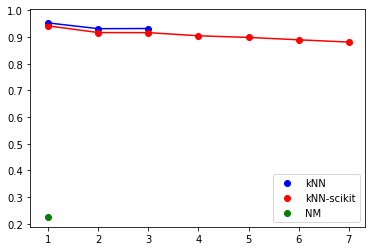

In [26]:
print("kNN accuracy_scores", signs_knn_acc_scr)
print("kNN-scikit accuracy_scores", scikit_knn_acc_scr[:3])
print("NM accuracy_score", nm_acc_scr)

plt.scatter(signs_k_for_knn, signs_knn_acc_scr, c='b', label='kNN')
plt.plot(signs_k_for_knn, signs_knn_acc_scr, c='b') # Dodawanie linii miedzy punktami

plt.scatter(scikit_k_for_knn, scikit_knn_acc_scr, c='r', label='kNN-scikit')
plt.plot(scikit_k_for_knn, scikit_knn_acc_scr, c='r')

plt.scatter(1, nm_acc_scr, c='g', label='NM')

plt.legend(loc='lower right')
plt.show()

### Porównanie wyników klasyfikatorów przy klasyfikacji znaków (z cechami wybranymi przeze mnie)

#### Confusion matrices and accuracy scores:

Z confusion matrix dla k=3 dla mojej implementacji oraz implementacji z biblioteki widać, że jest podobna dokladność wyników (implementacja z scikit jest okolo 1% lepsza przy k=3). 

#### Execution times:

Z powodów optymalizayjnych, wykonałem uczenie klasyfikatora kNN w mojej implementacji tylko dla k=<1,3>, gdyż nawet dla czterokrotnie mniejszego zbioru danych oraz braniu pod uwagę tylko cech numerycznych (145253 x 10) czas wykonania klasyfikacji był ~18 min. 

Dla porównania klasyfikacja przy użyciu kNN z scikit dla k=<1,7> wykonała się w ~1 min

#### Wykres k vs accuracy

Z wyresu powyżej widać, że accuracy_score obu implementacji kNN dla k=<1,3> jest podobny (ok. 93%). Natomiast wynik dla NM jest znacznie niższy (ok. 23%). 

Stało się tak dlatego, iż metoda NM jest podatna na niepoprawne próbki które mają wpływ na położenie centroidu. 